In [ ]:
!pip install transformers==4.45.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

Logits shape: torch.Size([1, 352, 352])


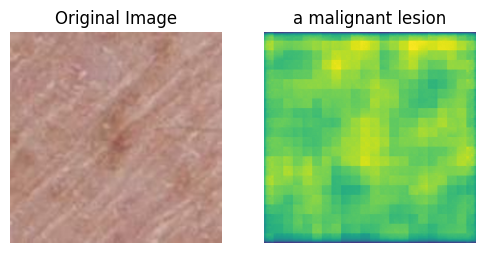

In [ ]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from torchvision.transforms import functional as F
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np


# Load the model and processor
processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load the image
url = "/content/drive/MyDrive/ece592109/images/ISIC_0015670.jpg"
image = Image.open(url).convert("RGB")

# Resize the image explicitly to match model's expected input size
image = image.resize((224, 224))
original_image = image
# Define prompts
texts = ["a malignant lesion"]

# Preprocess the image and text
# The processor will further normalize the inputs for the model
inputs = processor(
    text=texts,
    images=[image] * len(texts),  # Repeat the resized image for each prompt
    return_tensors="pt",
)

# Perform segmentation
with torch.no_grad():
    outputs = model(**inputs)

# Extract the logits
logits = outputs.logits  # Segmentation outputs
print("Logits shape:", logits.shape)  # Should be (len(texts), 1, 224, 224)

# Apply sigmoid to convert logits to probabilities
probabilities = torch.sigmoid(logits)  # Shape: (len(texts), H, W)

# Create subplots
_, ax = plt.subplots(1, len(texts) + 1, figsize=(3 * (len(texts) + 1), 4))
[a.axis('off') for a in ax.flatten()]

# Display the original image
ax[0].imshow(original_image)
ax[0].set_title("Original Image")

# Display each segmentation map
for i, (prompt, prob_map) in enumerate(zip(texts, probabilities)):
    # Convert the probability map to NumPy
    ax[i + 1].imshow(prob_map.cpu().numpy(), cmap="viridis")
    ax[i + 1].set_title(prompt)

plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
from transformers import AutoProcessor, CLIPSegForImageSegmentation, CLIPProcessor, CLIPModel
from PIL import Image
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
#from torchvision.transforms import functional as F
#from torchvision.transforms import InterpolationMode
import torch.nn.functional as F

# Load the CLIPSeg model and processor for segmentation
seg_model_name = "CIDAS/clipseg-rd64-refined"
seg_processor = AutoProcessor.from_pretrained(seg_model_name)
seg_model = CLIPSegForImageSegmentation.from_pretrained(seg_model_name)

# Load the CLIP model and processor for classification
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name)


def preprocess_with_segmentation(image_path, target_seg, texts=["a skin lesion"], save_path="segmented_image.png"):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    seg_target = Image.open(target_seg).convert("RGB")
    seg_inputs = seg_processor(
        text=texts, images=[image]* len(texts), return_tensors="pt"
    )

    # Generate segmentation mask
    with torch.no_grad():
        seg_outputs = seg_model(**seg_inputs)
    logits = seg_outputs.logits
    probabilities = torch.sigmoid(logits)
        #mask = torch.sigmoid(seg_outputs.logits[0, 0])  # Extract single-channel mask

    # Add batch and channel dimensions for resizing
    #mask = mask.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

    # Resize mask to match the input image size
    # mask_resized = F.interpolate(
    #     mask,
    #     size=(image.size[1], image.size[0]),  # (Height, Width)
    #     mode="bilinear",  # Use bilinear interpolation
    #     align_corners=False
    # ).squeeze(0).squeeze(0).cpu().numpy()  # Remove extra dimensions and convert to numpy

    # Apply mask to isolate the lesion

    #image_array = np.array(image)
    #mask_array = (mask_resized > 0.5).astype(np.uint8)  # Thresholded mask
    #segmented_image = image_array * mask_array[..., None]  # Apply mask to all channels
    prob_map = probabilities[0, 0].cpu().numpy()

    # # Convert the probability map to a heatmap (rescaled to 0-255)
    # prob_map_rescaled = (prob_map * 255).astype(np.uint8)  # Scale to 0-255
    # heatmap = Image.fromarray(prob_map_rescaled).convert("RGB")  # Convert to RGB

    # # Overlay heatmap for visualization (Optional: for user to see input + segmentation)
    # # Uncomment if overlay is required
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(image)
    # plt.title("Original Image")
    # plt.axis("off")
    # plt.subplot(1, 2, 2)
    # plt.imshow(heatmap, cmap="viridis")
    # plt.title("Segmentation Heatmap")
    # plt.axis("off")
    # plt.show()

    # return heatmap
    #plt.subplot(1, 2, 2)
    # Create subplots
    _, ax = plt.subplots(1, len(texts) + 1, figsize=(3 * (len(texts) + 1), 4))
    [a.axis('off') for a in ax.flatten()]

    # Display the original image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    # Display each segmentation map
    for i, (prompt, prob_map) in enumerate(zip(texts, probabilities)):
        # Convert the probability map to NumPy
        prob_map_np = prob_map.cpu().numpy()
        ax[i + 1].imshow(prob_map.cpu().numpy(), cmap="viridis")
        ax[i + 1].set_title(prompt)
        plt.imsave(save_path, prob_map_np, cmap="viridis")

    plt.show()
    seg_img = Image.open(save_path).convert("RGB")
    return seg_img, seg_inputs

    #return Image.fromarray(segmented_image)



# Function to classify an image using zero-shot classification
def classify_image_with_clip(image_path, prompts=["benign", "malignant"]):
    # Segment the lesion
    segmented_image, seg_inputs = preprocess_with_segmentation(image_path, target_seg)
    image = Image.open(image_path).convert("RGB")
    # Process the segmented image with CLIP
    inputs = clip_processor(
        text=prompts, images=image, return_tensors="pt", padding=True
    )

    # Forward pass to get embeddings
    with torch.no_grad():
        image_features = clip_model.get_image_features(inputs["pixel_values"])
        text_features = clip_model.get_text_features(inputs["input_ids"])

    # Normalize features for cosine similarity
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    similarities = (image_features @ text_features.T).squeeze(0).cpu().numpy()

    # Get the predicted class
    predicted_idx = similarities.argmax()
    predicted_label = prompts[predicted_idx]

    return segmented_image, predicted_label, similarities

# Path to the folder containing images
image_folder = "/content/drive/MyDrive/ece592109/images"  # Replace with your folder path
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]

# Load ground truth labels for evaluation
ground_truth = pd.read_csv("/content/drive/MyDrive/ece592109/train-metadata.csv")
ground_truth = ground_truth.set_index("isic_id")  # Set index for easy access

# Classify all images in the folder and calculate loss
results = []
classification_losses = []

for img_path in image_paths:
    # Extract the image ID from the file path
    image_id = os.path.basename(img_path).replace(".jpg", "")

    # Perform classification
    segmented_image, predicted_label, similarities = classify_image_with_clip(
        img_path, prompts=["benign", "malignant"]
    )

    # Get the ground truth label (as probability)
    if image_id in ground_truth.index:
        ground_truth_label = ground_truth.loc[image_id, "target"]  # Ground truth probability (0 or 1)
    else:
        ground_truth_label = None  # Handle missing labels

    if ground_truth_label is not None:
        # Convert similarities to probabilities using softmax
        probabilities = torch.softmax(torch.tensor(similarities), dim=0).numpy()

        # Calculate log loss
        true_label_vector = [1 - ground_truth_label, ground_truth_label]  # [P(benign), P(malignant)]
        loss = log_loss([true_label_vector], [probabilities])
        classification_losses.append(loss)

    # Append the results
    results.append({
        "image_id": image_id,
        "predicted_label": predicted_label,
        "ground_truth_label": "malignant" if ground_truth_label == 1 else "benign",
        "similarities": similarities,
        "loss": loss if ground_truth_label is not None else None,
    })

    # Display the segmented image and prediction
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(img_path))
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title(f"Prediction: {predicted_label}\nGround Truth: {'malignant' if ground_truth_label == 1 else 'benign'}")
    plt.axis("off")
    plt.show()

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the classification losses
plt.figure(figsize=(10, 6))
plt.plot(classification_losses, label="Classification Loss", marker='o')
plt.title("Classification Loss per Image")
plt.xlabel("Image Index")
plt.ylabel("Log Loss")
plt.legend()
plt.grid()
plt.show()

# Print average loss
average_loss = np.mean(classification_losses)
print(f"Average Classification Loss: {average_loss:.4f}")

# Print the results
print("\nClassification Results:")
print(results_df[["image_id", "predicted_label", "ground_truth_label", "loss"]])

# Evaluate accuracy
correct_predictions = results_df[
    results_df["predicted_label"] == results_df["ground_truth_label"]
]
accuracy = len(correct_predictions) / len(results_df)
print(f"\nAccuracy: {accuracy * 100:.2f}%")


In [ ]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import pandas as pd
import os
import numpy as np

# Load the base CLIPSeg model and processor
processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Add a classification head to the model
class JointCLIPSegModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.clipseg = base_model
        self.classifier = nn.Linear(512, 1)  # Binary classification head

    def forward(self, pixel_values, input_ids, attention_mask):
        # Get segmentation logits from CLIPSeg
        seg_outputs = self.clipseg(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
        segmentation_logits = seg_outputs.logits

        # Extract a global feature (mean pooling of the segmentation logits)
        pooled_features = segmentation_logits.mean(dim=(-2, -1))  # Global average pooling

        # Predict binary class
        classification_logits = self.classifier(pooled_features)
        return segmentation_logits, classification_logits

# Wrap the model
joint_model = JointCLIPSegModel(model)

# Dataset class for loading images and labels
class ISICDataset(Dataset):
    def __init__(self, image_dir, metadata_file, processor, prompt="a skin lesion"):
        self.image_dir = image_dir
        self.metadata = pd.read_csv(metadata_file)
        self.processor = processor
        self.prompt = prompt

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Load image and label
        row = self.metadata.iloc[idx]
        target_seg = os.path.join(self.seg_image_dir, row['isic_id'] + '.jpg')
        image_path = os.path.join(self.image_dir, row['isic_id'] + '.jpg')
        image = Image.open(image_path).convert("RGB")
        label = torch.tensor(row['target'], dtype=torch.float)  # Binary label (0 or 1)

        # Preprocess image and text
        inputs = self.processor(
            text=[self.prompt],
            images=image,
            return_tensors="pt",
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": label
        }

# Define dataset and dataloaders
train_dataset = ISICDataset(
    seg_image_dir="/content/seg-train-image",
    image_dir="/content/train-image",
    metadata_file="/content/train-metadata.csv",
    processor=processor
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Define optimizer and loss functions
optimizer = optim.AdamW(joint_model.parameters(), lr=1e-4)
segmentation_loss_fn = nn.BCEWithLogitsLoss()  # For segmentation
classification_loss_fn = nn.BCEWithLogitsLoss()  # For classification

# Fine-tuning loop
joint_model.train()
num_epochs = 10

for epoch in range(num_epochs):
    total_seg_loss = 0
    total_cls_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        seg_logits, cls_logits = joint_model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        # Compute segmentation loss
        seg_loss = segmentation_loss_fn(seg_logits, batch["pixel_values"])

        # Compute classification loss
        cls_loss = classification_loss_fn(cls_logits.squeeze(-1), batch["label"])

        # Combine losses
        total_loss = seg_loss + cls_loss
        total_loss.backward()
        optimizer.step()

        total_seg_loss += seg_loss.item()
        total_cls_loss += cls_loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Segmentation Loss: {total_seg_loss / len(train_loader):.4f}")
    print(f"Classification Loss: {total_cls_loss / len(train_loader):.4f}")

# Save the fine-tuned model
torch.save(joint_model.state_dict(), "joint_clipseg_model.pth")


run from here:

In [ ]:
!pip install streamlit pyngrok transformers torch torchvision matplotlib

In [ ]:
!pip install transformers==4.45.0

In [ ]:
%%writefile app.py


import streamlit as st
import os
from transformers import AutoProcessor, CLIPSegForImageSegmentation, CLIPProcessor, CLIPModel, AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openai
import torch.nn.functional as F

# Load the CLIPSeg model and processor for segmentation
seg_model_name = "CIDAS/clipseg-rd64-refined"
seg_processor = AutoProcessor.from_pretrained(seg_model_name)
seg_model = CLIPSegForImageSegmentation.from_pretrained(seg_model_name)

# Load the CLIP model and processor for classification
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name)

# Load GPT-4 model and tokenizer (use Hugging Face's GPT-4 equivalent model)
gpt4_model_name = "gpt4"  # Replace with the correct Hugging Face model name
gpt4_tokenizer = AutoTokenizer.from_pretrained(gpt4_model_name)
gpt4_model = AutoModelForCausalLM.from_pretrained(gpt4_model_name)

def dice_loss(pred, target):
  """
  Calculates the Dice Loss function for binary segmentation tasks.

  Args:
      pred: Predicted segmentation probabilities (torch.Tensor).
      target: Ground truth segmentation labels (torch.Tensor).

  Returns:
      Dice loss value (float).
  """
  smooth = 1.0

  intersection = (pred * target).sum()
  union = pred.sum() + target.sum() + smooth

  dice = (2.0 * intersection) / union

  return 1 - dice
# Segmentation function
def preprocess_with_segmentation(image):
    #image = Image.open(image).convert("RGB")

    texts = ["a skin lesion"]
    seg_inputs = seg_processor(text= texts, images=[image]*len(texts), return_tensors="pt")


    # Perform segmentation
    with torch.no_grad():
        seg_outputs = seg_model(**seg_inputs)
    logits = seg_outputs.logits
    probabilities = torch.sigmoid(logits)

    # Extract segmentation heatmap
    save_path = "segmented_image.png"
    prob_map = probabilities[0, 0].cpu().numpy()
    for i, (prompt, prob_map) in enumerate(zip(texts, probabilities)):
        # Convert the probability map to NumPy
        prob_map_np = prob_map.cpu().numpy()
        # ax[i + 1].imshow(prob_map.cpu().numpy(), cmap="viridis")
        # ax[i + 1].set_title(prompt)
        plt.imsave(save_path, prob_map_np, cmap="viridis")

    # plt.show()
    seg_img = Image.open(save_path).convert("RGB")
    #dice loss
    loss = dice_loss(outputs, targets)
    #return seg_img, seg_inputs
    return seg_img

# Classification function
def classify_image_with_clip(image, prompts=["benign", "malignant"]):
    # Process the segmented image with CLIP
    inputs = clip_processor(text=prompts, images=image, return_tensors="pt", padding=True)

    # Forward pass to get embeddings
    with torch.no_grad():
        image_features = clip_model.get_image_features(inputs["pixel_values"])
        text_features = clip_model.get_text_features(inputs["input_ids"])

    # Normalize features for cosine similarity
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    similarities = (image_features @ text_features.T).squeeze(0).cpu().numpy()

    # Get the predicted class
    predicted_idx = similarities.argmax()
    predicted_label = prompts[predicted_idx]

    return predicted_label, similarities

# Chat function using GPT-4
def chat_with_gpt4(question, context):
    # Combine the context and question
    input_text = f"Context: {context}\nQuestion: {question}\nAnswer:"
    input_ids = gpt4_tokenizer.encode(input_text, return_tensors="pt")

    # Generate response
    with torch.no_grad():
        output_ids = gpt4_model.generate(input_ids, max_length=200, num_return_sequences=1)

    # Decode the response
    response = gpt4_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return response

# Streamlit app
st.title("Skin Lesion Analysis with Segmentation, Classification, and Chat")

# Image upload
uploaded_file = st.file_uploader("Upload an Image", type=["jpg", "jpeg", "png"])
target = st.file_uploader("Upload target", type=["jpg", "jpeg", "png"])
if uploaded_file is not None:
    # Load and display the uploaded image
    file_name_without_extension = os.path.splitext(uploaded_file.name)[0]
    st.write(file_name_without_extension)
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)
    # st.write(image.size)
    # image = image.resize((224, 224))
    # st.write(image.size)

    # Perform segmentation
    st.write("Performing segmentation...")
    prob_map = preprocess_with_segmentation(image)
    plt.imshow(prob_map, cmap="viridis")
    plt.axis("off")
    plt.title("Segmentation Heatmap")
    st.pyplot()

    # Perform classification
    st.write("Classifying the segmented lesion...")
    predicted_label, similarities = classify_image_with_clip(image)
    st.write(f"Predicted Label: {predicted_label}")
    #st.write(f"Similarities: {similarities}")

    # Chat box
    st.write("Ask questions about the image or result:")
    user_question = st.text_input("Your Question:")
    if user_question:
        # Generate GPT-4 response
        context = f"Image shows a lesion classified as {predicted_label} with segmentation results."
        answer = chat_with_gpt4(user_question, context)
        st.write("GPT-4 Answer:")
        st.write(answer)


Overwriting app.py


In [ ]:
# !git clone https://github.com/siddhardhan23/multiple-disease-prediction-streamlit-app.git

fatal: destination path 'multiple-disease-prediction-streamlit-app' already exists and is not an empty directory.


In [ ]:

# !pip install -r "/content/multiple-disease-prediction-streamlit-app/requirements.txt"

In [ ]:
!pip install pyngrok
!pip install streamlit

In [ ]:
# %%writefile app.py

# import streamlit as st

# st.title("My First Streamlit App")

# st.write("Hello, world!")

# if st.button("Click me"):
#     st.write("Button clicked!")

In [ ]:
import os
from threading import Thread
from pyngrok import ngrok

In [ ]:
ngrok.set_auth_token('') #you need to give authorization token for the gpt model to run

In [ ]:
import os
import threading
from flask import Flask, render_template
from pyngrok import ngrok
import streamlit as st
from transformers import AutoProcessor, CLIPSegForImageSegmentation, CLIPProcessor, CLIPModel, AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import subprocess

# Flask app setup
app = Flask(__name__)
port = "5000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"")

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# Define Flask routes
@app.route("/")
def index():
    return "Hello from Flask! Streamlit app is running at: " + public_url

# Function to run the Streamlit app
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py", "--server.port", str(port)])

# Start the Flask server in a new thread
#threading.Thread(target=app.run, kwargs={"use_reloader": False, "port": int(port)}).start()

# Start the Streamlit app in another thread
threading.Thread(target=run_streamlit).start()


 * ngrok tunnel "https://eddf-35-229-209-87.ngrok-free.app" -> "http://127.0.0.1:5000"


#Fine-tuning part

In [ ]:
import os
from PIL import Image
import torch
import numpy as np

def dice_loss(pred, target):
    smooth = 1.0  # Smoothing factor to avoid division by zero

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + smooth

    dice = (2.0 * intersection) / union
    return 1 - dice


# Fine-tuning the CLIPSeg model
def fine_tune_clipseg(model, processor, train_images, train_masks, epochs=5, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train() 
    for epoch in range(epochs):
        epoch_loss = 0.0
        for image, mask in zip(train_images, train_masks):
            inputs = processor(images=[image], text=["a lesion"], return_tensors="pt")
            targets = mask.unsqueeze(0) 
            outputs = model(**inputs)
            logits = outputs.logits.squeeze(0) 
            loss = dice_loss(torch.sigmoid(logits), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    print("Fine-tuning complete.")


def load_images_from_directory(image_dir):
    images = []
    for file_name in sorted(os.listdir(image_dir)): 
        file_path = os.path.join(image_dir, file_name)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            images.append(Image.open(file_path).convert("RGB"))
    return images

def load_masks_from_directory(mask_dir):
    masks = []
    for file_name in sorted(os.listdir(mask_dir)): 
        file_path = os.path.join(mask_dir, file_name)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.npy')):
            if file_path.endswith('.npy'):
                mask = np.load(file_path)
            else:
                mask = np.array(Image.open(file_path).convert("L"))  
            masks.append(torch.tensor(mask, dtype=torch.float32))  
    return masks

image_dir = "/content/train-image"
mask_dir = "/content/train-image-masks" 
train_images = load_images_from_directory(image_dir)
train_masks = load_masks_from_directory(mask_dir)
fine_tune_clipseg(seg_model, seg_processor, train_images, train_masks)


After running the fine tuning cell, again run the above app.py file and copy the above code for the segmentation part to the app.py file before using streamlit

##Medical Segmentation code:

In [ ]:
segestic/phi3.5-mini-4k-qlora-medical-seg-v4

In [ ]:
import os
from PIL import Image
import torch
import numpy as np
from transformers import AutoProcessor, AutoModelForImageSegmentation

def dice_loss(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + smooth
    dice = (2.0 * intersection) / union
    return 1 - dice

def load_images_from_directory(image_dir):
    images = []
    for file_name in sorted(os.listdir(image_dir)): 
        file_path = os.path.join(image_dir, file_name)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            images.append(Image.open(file_path).convert("RGB"))
    return images

def load_masks_from_directory(mask_dir):
    masks = []
    for file_name in sorted(os.listdir(mask_dir)): 
        file_path = os.path.join(mask_dir, file_name)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.npy')):
            if file_path.endswith('.npy'):
                mask = np.load(file_path) 
            else:
                mask = np.array(Image.open(file_path).convert("L")) 
            masks.append(torch.tensor(mask, dtype=torch.float32)) 
    return masks

def fine_tune_medseg(model, processor, train_images, train_masks, epochs=5, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        epoch_loss = 0.0
        for image, mask in zip(train_images, train_masks):
            # Prepare inputs
            inputs = processor(images=[image], return_tensors="pt")
            targets = mask.unsqueeze(0)  # Add batch dimension

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits.squeeze(0)  # Remove batch dimension
            loss = dice_loss(torch.sigmoid(logits), targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    print("Fine-tuning complete.")

medseg_model_name = "segestic/phi3.5-mini-4k-qlora-medical-seg-v4"  
processor = AutoProcessor.from_pretrained(medseg_model_name)
model = AutoModelForImageSegmentation.from_pretrained(medseg_model_name)
image_dir = "/content/train-image" 
mask_dir = "/content/train-image-masks"
train_images = load_images_from_directory(image_dir)
train_masks = load_masks_from_directory(mask_dir)

fine_tune_medseg(model, processor, train_images, train_masks)

model.save_pretrained("fine_tuned_medseg")
processor.save_pretrained("fine_tuned_medseg")


After running the fine tuning cell, again run the above app.py file and copy the above code for the segmentation part to the app.py file before using streamlit